In [3]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
sys.path.insert(0, os.path.abspath('/home/gaspar/git/pyha'))

# Overview
Demodulator can take back the modulation step.

## Modulated signal
I use the previously developed FSK modulator component. To first synthesize a testing signal.

<IPython.core.display.Javascript object>


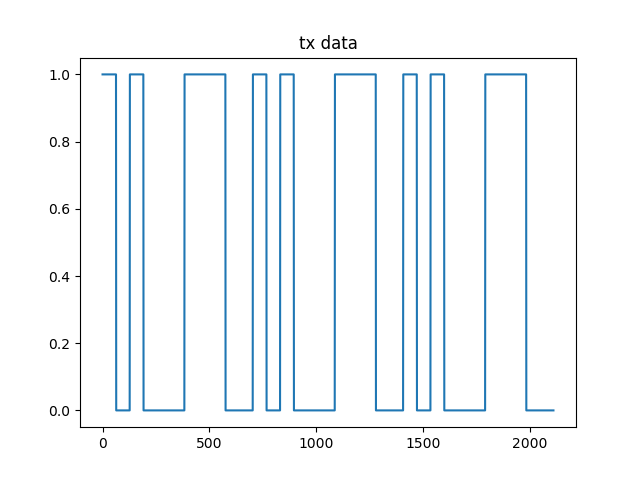

<IPython.core.display.Javascript object>


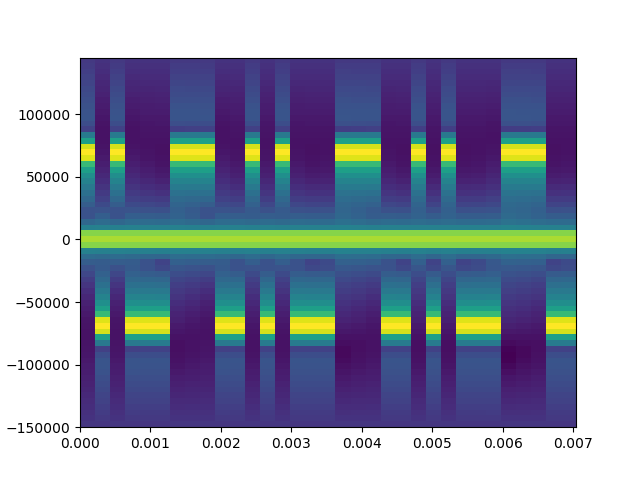

In [36]:
from pyha.components.fsk_modulator import FSKModulator
samples_per_symbol = 64 # this is so high to make stuff plottable
symbols = [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0]

data = []
for x in symbols:
    data.extend([x] * samples_per_symbol)
    
plt.plot(data)
plt.title('tx data')
plt.show()

fs = 300e3
deviation = 70e3
mod = FSKModulator(deviation, fs)

tx_signal = mod.model_main(data)

# awgn channel (add some noise)
tx_signal = tx_signal + np.random.normal(scale=np.sqrt(0.1))

Pxx, freqs, bins, im = plt.specgram(tx_signal, Fs=fs, NFFT=64, noverlap=0)
plt.show()

## Demodulator

We use quadrature demodulator to turn RF back to data.

<IPython.core.display.Javascript object>


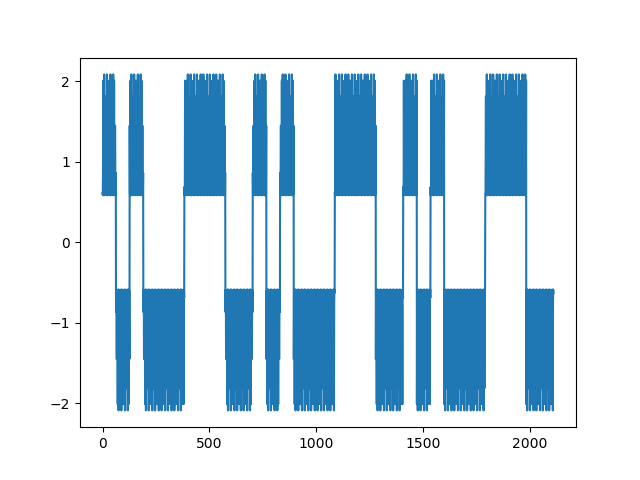

In [25]:
gain = fs / (2 * np.pi * deviation)
demod = np.angle(tx_signal[1:] * np.conjugate(tx_signal[:-1]))
rx_demod = gain * demod

plt.plot(fix_gain)
# plt.plot(data)
plt.show()

# Matched filtering
We can inprove the noise situation by using matched filtering.

<IPython.core.display.Javascript object>


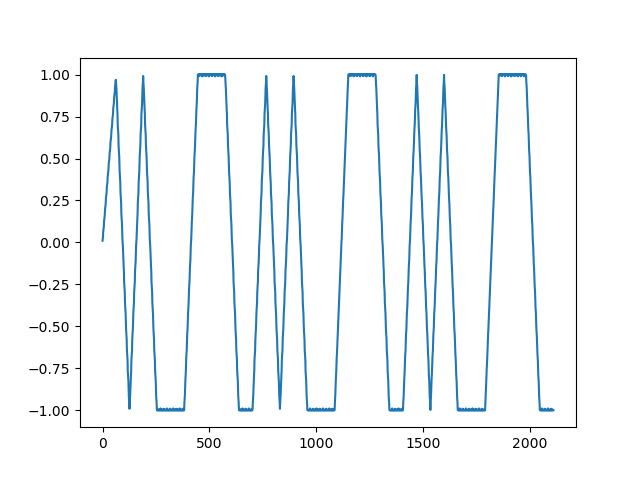

In [35]:
from pyha.components.moving_average import MovingAverage
mf = MovingAverage(window_len=samples_per_symbol)

rx_matched = mf.model_main(rx_demod)

plt.plot(rx_matched)
plt.show()


Now the signal should be sampled at positive/negative peaks in order to recover bit-stream.

# Pyha implementation
For hardware NCO component is used, it is also build using Pyha, you can look sources HERE. Alternitively this could be implemented by lookup tables.

In [ ]:
import numpy as np

from pyha.common.const import Const
from pyha.common.hwsim import HW
from pyha.common.sfix import ComplexSfix, resize, Sfix, fixed_truncate
from pyha.components.cordic import Angle
from pyha.components.util_complex import Conjugate, ComplexMultiply


class QuadratureDemodulator(HW):
    def __init__(self, gain):
        self.gain = gain

        # components / registers
        self.conjugate = Conjugate()
        self.complex_mult = ComplexMultiply()
        self.angle = Angle()
        self.out = Sfix()

        # constants
        # pi term puts angle output to pi range
        self.gain_sfix = Const(Sfix(self.gain * np.pi, 3, -14))
        
        self._delay = self.conjugate._delay + \
                     self.complex_mult._delay + \
                     self.angle._delay + 1

    def main(self, c):
        """ This is HW model, to be converted to VHDL """
        conj = self.conjugate.main(c)
        mult = self.complex_mult.main(c, conj)
        angle = self.angle.main(mult)
        fix_gain = resize(self.gain_sfix * angle, c.real, round_style=fixed_truncate)

        # output register
        self.next.out = fix_gain
        return self.out

    def model_main(self, c):
        """ Model that verification is ran against """
        demod = np.angle(c[1:] * np.conjugate(c[:-1]))
        fix_gain = self.gain * demod / np.pi
        return fix_gain
